# CNN on GPU for HAR with Ambient Sensors (GPU!)

## 1. Load the data

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt

In [2]:
# try to fix tensorflow gpu problems
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# check gpu support
gpus = tf.config.list_physical_devices('GPU')
print(len(gpus))
print(tf.test.is_built_with_gpu_support())
print(tf.test.is_built_with_cuda())
print(tf.test.gpu_device_name())

1
True
True
/device:GPU:0


In [4]:
filename = 'csh110'
# globalpath ='/media/alex/Data/Datasets_for_ML/HAR/casas-dataset/'
globalpath ='/casas-dataset/' # for docker ml path!
filepath = globalpath + filename + '/' + filename + '.ann.features.csv' 
# filepath = '/media/alex/Data/Datasets_for_ML/HAR/casas-dataset/csh101/csh101.ann.features.csv'
df = pd.read_csv(filepath)
df.head(5)

,lastSensorEventHours,lastSensorEventSeconds,lastSensorDayOfWeek,windowDuration,timeSinceLastSensorEvent,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,...,sensorElTime-Chair,sensorElTime-DiningRoom,sensorElTime-Hall,sensorElTime-Ignore,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-Office,sensorElTime-OutsideDoor,sensorElTime-WorkArea,activity
0,3.0,11131.0,2.0,10942.0,590.0,0.0,0.0,1.0,1.0,1.0,...,86400.0,86400.0,86400.0,590.491697,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep
1,3.0,11132.0,2.0,10068.0,1.0,0.0,0.0,1.0,1.0,1.0,...,86400.0,86400.0,86400.0,591.597136,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep
2,3.0,11141.0,2.0,9752.0,9.0,0.0,0.0,5.0,5.0,1.0,...,86400.0,86400.0,86400.0,0.000000,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep
3,3.0,11588.0,2.0,9324.0,447.0,0.0,0.0,5.0,5.0,1.0,...,86400.0,86400.0,86400.0,0.000000,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep
4,3.0,11740.0,2.0,9151.0,152.0,0.0,0.0,5.0,5.0,1.0,...,86400.0,86400.0,86400.0,0.000000,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep


In [5]:
print(df.shape)

(136716, 37)


## 2. Inspect Data

### 2.1 Data description

**lastSensorEventHours:** (integer)  Hour of the day, in local time (min= 0.0, max=23.0)  
**lastSensorEventSeconds (decimal):** Seconds since midnight, in local time (count = 407481 min=1.0 max=86395.0)  
**lastSensorDayOfWeek (symbolic-valued integer):**  Integer day of the week, in local time (count=407481, min=0.0 max=6.0)  
**windowDuration (decimal):**  Time duration of the 30 event sliding window in seconds. count=407481, min=7.0 max=39269.0)  
**timeSinceLastSensorEvent (decimal):**  Seconds since the last sensor event. count = 407481 min=0.0 max=32855.0)  
**prevDominantSensor1 (symbolic-valued integer):**  Dominant sensor ID from the previous window. (count = 407481 min=0.0 max=10.0)  
**prevDominantSensor2 (symbolic-valued integer):**  Dominant sensor ID from the second previous window. (count=407481 min=0.0 max=10.0)  
**lastSensorID (symbolic-valued integer):**  Last sensor ID in the window. (count=407481 min=0.0 max=10.0)  
**lastSensorLocation (symbolic-valued integer):**  Last sensor location ID in the window. (count=407481 min=0.0 max=10.0)   
**lastMotionLocation (symbolic-valued integer):**  Last motion sensor location ID in the window, can be -1 if none within the sliding window. (count =407481 min=-1.0 max=10.0)  
**sensorElTime-Chair (decimal):** The number of seconds since this sensor was last seen, up to a maximum of 86400. (count=407481 min=86400.0    max=86400.0)  
**sensorElTime-DiningRoom (decimal):** The number of seconds since this sensor was last seen, up to a maximum of 86400. (count=407481 min=0.0  max=86400.0)  
**sensorElTime-Hall (decimal):** The number of seconds since this sensor was last seen, up to a maximum of 86400. (count=407481 min=86400.0 max =86400.0)  
**sensorElTime-Ignore (decimal):** The number of seconds since this sensor was last seen, up to a maximum of 86400.  
**sensorElTime-Kitchen (decimal):** The number of seconds since this sensor was last seen, up to a maximum of 86400.  
**sensorElTime-LivingRoom (decimal):** The number of seconds since this sensor was last seen, up to a maximum of 86400.    
**sensorElTime-Office (decimal):** The number of seconds since this sensor was last seen, up to a maximum of 86400.  
**sensorElTime-OutsideDoor (decimal):**  The number of seconds since this sensor was last seen, up to a maximum of 86400.  
**sensorElTime-WorkArea (decimal):** The number of seconds since this sensor was last seen, up to a maximum of 86400.  
**activity (class label):**  The annotated activity that is currently being observed. 
    unique values:  \[ 'Bathe' 'Bed_Toilet_Transition' 'Cook' 'Cook_Breakfast' 'Cook_Dinner'
 'Cook_Lunch' 'Dress' 'Drink' 'Eat' 'Eat_Breakfast' 'Eat_Dinner'
 'Eat_Lunch' 'Enter_Home' 'Entertain_Guests' 'Groom' 'Leave_Home'
 'Morning_Meds' 'Other_Activity' 'Personal_Hygiene' 'Phone' 'Read' 'Relax'
 'Sleep' 'Sleep_Out_Of_Bed' 'Step_Out' 'Take_Medicine' 'Toilet'
 'Wash_Breakfast_Dishes' 'Wash_Dinner_Dishes' 'Wash_Dishes'
 'Wash_Lunch_Dishes' 'Watch_TV' 'Work' 'Work_At_Table'\]

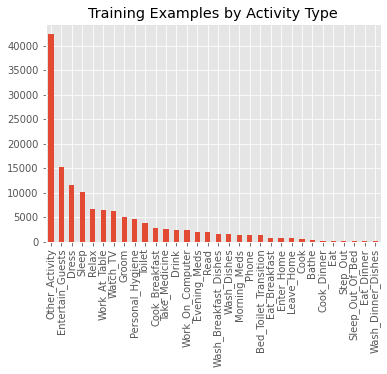

In [6]:
%matplotlib inline
plt.style.use('ggplot')
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

In [7]:
df['activity'].value_counts(normalize=True)

Other_Activity           0.309115
Entertain_Guests         0.111648
Dress                    0.083926
Sleep                    0.073510
Relax                    0.048341
Work_At_Table            0.046527
Watch_TV                 0.045679
Groom                    0.036002
Personal_Hygiene         0.033654
Toilet                   0.027063
Cook_Breakfast           0.020063
Take_Medicine            0.019061
Drink                    0.017942
Work_On_Computer         0.016545
Evening_Meds             0.014775
Read                     0.014585
Wash_Breakfast_Dishes    0.011959
Wash_Dishes              0.011498
Morning_Meds             0.010474
Phone                    0.009787
Bed_Toilet_Transition    0.009428
Eat_Breakfast            0.006027
Enter_Home               0.005603
Leave_Home               0.005588
Cook                     0.003606
Bathe                    0.001902
Cook_Dinner              0.001565
Eat                      0.001521
Step_Out                 0.000966
Sleep_Out_Of_B

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136716 entries, 0 to 136715
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   lastSensorEventHours      136716 non-null  float64
 1   lastSensorEventSeconds    136716 non-null  float64
 2   lastSensorDayOfWeek       136716 non-null  float64
 3   windowDuration            136716 non-null  float64
 4   timeSinceLastSensorEvent  136716 non-null  float64
 5   prevDominantSensor1       136716 non-null  float64
 6   prevDominantSensor2       136716 non-null  float64
 7   lastSensorID              136716 non-null  float64
 8   lastSensorLocation        136716 non-null  float64
 9   lastMotionLocation        136716 non-null  float64
 10  complexity                136716 non-null  float64
 11  activityChange            136716 non-null  float64
 12  areaTransitions           136716 non-null  float64
 13  numDistinctSensors        136716 non-null  f

## Drop Rare Activities

In [9]:
# get the count of each value
value_counts = df['activity'].value_counts()
# select the values where the count less than 2%
threshhold = int(2*len(df['activity'])/100)
# remove rows where counts less than threshhold
to_remove = value_counts[value_counts <= threshhold].index
# keep other rows
df = df[~df.activity.isin(to_remove)]
df['activity'].value_counts(normalize=False)

Other_Activity      42261
Entertain_Guests    15264
Dress               11474
Sleep               10050
Relax                6609
Work_At_Table        6361
Watch_TV             6245
Groom                4922
Personal_Hygiene     4601
Toilet               3700
Cook_Breakfast       2743
Name: activity, dtype: int64

## Encode Data

In [10]:
enc = preprocessing.LabelEncoder()
LABELS = list(df['activity'].unique())
df['ActivityEncoded'] = enc.fit_transform(df['activity'].values.ravel())
df.head()

,lastSensorEventHours,lastSensorEventSeconds,lastSensorDayOfWeek,windowDuration,timeSinceLastSensorEvent,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,...,sensorElTime-DiningRoom,sensorElTime-Hall,sensorElTime-Ignore,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-Office,sensorElTime-OutsideDoor,sensorElTime-WorkArea,activity,ActivityEncoded
0,3.0,11131.0,2.0,10942.0,590.0,0.0,0.0,1.0,1.0,1.0,...,86400.0,86400.0,590.491697,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep,7
1,3.0,11132.0,2.0,10068.0,1.0,0.0,0.0,1.0,1.0,1.0,...,86400.0,86400.0,591.597136,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep,7
2,3.0,11141.0,2.0,9752.0,9.0,0.0,0.0,5.0,5.0,1.0,...,86400.0,86400.0,0.000000,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep,7
3,3.0,11588.0,2.0,9324.0,447.0,0.0,0.0,5.0,5.0,1.0,...,86400.0,86400.0,0.000000,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep,7
4,3.0,11740.0,2.0,9151.0,152.0,0.0,0.0,5.0,5.0,1.0,...,86400.0,86400.0,0.000000,86400.0,86400.0,86400.0,86400.0,86400.0,Sleep,7


## Train-Test Split Data

In [11]:
df = df.drop(columns=['activity'])
dataset = df.values
train_dataset, test_dataset = train_test_split(dataset,
                                               test_size=0.3,
                                               shuffle=False)

print(train_dataset.shape)
print(test_dataset.shape)

(79961, 37)
(34269, 37)


## Scale Data

In [12]:
X_train = train_dataset[:, :-1]
Y_train = train_dataset[:, -1].reshape(-1,1)
X_test = test_dataset[:, :-1]
Y_test = test_dataset[:, -1].reshape(-1,1)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(79961, 36) (79961, 1)
(34269, 36) (34269, 1)


In [13]:
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
# convert to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

## Prepare Data for CNN

In [14]:
# one-hot encoding
y_train_hot = tf.keras.utils.to_categorical(Y_train)
y_test_hot = tf.keras.utils.to_categorical(Y_test)
print(y_train_hot.shape)
print(y_test_hot.shape)

(79961, 11)
(34269, 11)


## Create CNN

In [15]:
num_classes = enc.classes_.size
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
input_shape = (X_train.shape[1], 1)
print(num_classes)
print(input_shape)

11
(36, 1)


In [16]:
model = Sequential()
model.add(Conv1D(filters=32,
                 kernel_size=2,
                 activation='relu',
                 input_shape=input_shape))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 35, 32)            96        
_________________________________________________________________
flatten (Flatten)            (None, 1120)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                35872     
_________________________________________________________________
dense_1 (Dense)              (None, 11)                363       
Total params: 36,331
Trainable params: 36,331
Non-trainable params: 0
_________________________________________________________________
None


## Fit DNN

In [17]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  min_delta=0.0001,
                                                  patience=10,
                                                  verbose=0,
                                                  mode='auto',
                                                  restore_best_weights=True)

In [19]:
# hyperparameters
BATCH_SIZE = 512
EPOCHS = 50
history = model.fit(X_train,
                    y_train_hot,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_test, y_test_hot),
                    callbacks=[early_stopping],
                    verbose=0)

## Plotting the Results

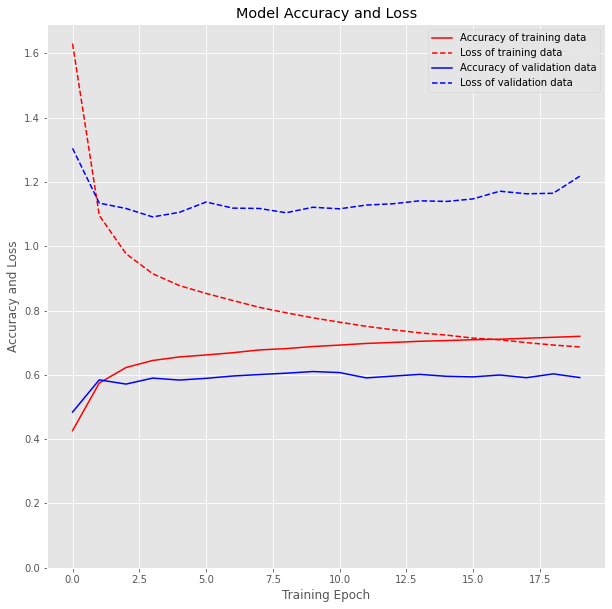

In [20]:
loss = history.history['loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
plt.figure(figsize=(10,10))
plt.plot(acc, 'r', label='Accuracy of training data')
plt.plot(loss, 'r--', label='Loss of training data')
plt.plot(val_acc, 'b', label='Accuracy of validation data')
plt.plot(val_loss, 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

## Check Against Test Data

In [21]:
score = model.evaluate(X_test, y_test_hot, verbose=0)
print(f'Accuracy on test data: {score[1]*100:.1f}')

Accuracy on test data: 61.0


In [22]:
# print confusion matrix for test data
y_pred_test = model.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
print(classification_report(Y_test, max_y_pred_test))

              precision    recall  f1-score   support

         0.0       0.94      0.76      0.84       783
         1.0       0.43      0.70      0.53      2989
         2.0       0.42      0.26      0.32      3266
         3.0       0.71      0.86      0.78      1888
         4.0       0.66      0.63      0.64     13351
         5.0       0.76      0.68      0.72      1777
         6.0       0.36      0.39      0.38      1570
         7.0       0.71      0.71      0.71      2376
         8.0       0.41      0.41      0.41      1115
         9.0       0.65      0.68      0.66      2499
        10.0       0.73      0.64      0.68      2655

    accuracy                           0.61     34269
   macro avg       0.62      0.61      0.61     34269
weighted avg       0.62      0.61      0.61     34269



In [23]:
print(f'MCC: {matthews_corrcoef(Y_test, max_y_pred_test):.2f}')

MCC: 0.52
